# SAE Steering
This notebook steers a text generation by identifying a neuron that corresponds to a certain concept and manually activating it during inference.

The steps are:
* Create a few samples that share a common feature; in this example, it's "baseball".
* Collect the SAE activations of the last position when inferring w/ each sample as context.
* Identify neuron activations that were common to each sample.
* Force each neuron individually to a high value and complete an open ended prompt.

In [1]:
import os
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
os.environ["SPARSIFY_DISABLE_TRITON"] = "1"
from sparsify import Sae
import matplotlib.pyplot as plt

/home/kyle/micromamba/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Triton disabled, using eager implementation of sparse decoder.


In [2]:
SAE_NAME = "EleutherAI/sae-llama-3-8b-32x"
MODEL_NAME = "meta-llama/Meta-Llama-3-8B"
DEVICE="cpu"

In [3]:
# Don't do this, it downloads an SAE for every layer which is massive.
# saes = Sae.load_many(SAE_NAME)

# Loading model + SAE is very large in bf16 so infer this on the CPU.
# Layer 24's SAE is the only one that's fully trained.
sae = Sae.load_from_hub("EleutherAI/sae-llama-3-8b-32x", hookpoint="layers.24", device=DEVICE)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME).to(DEVICE)

Fetching 2 files: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 56299.38it/s]
Dropping extra args {'signed': False}
Loading checkpoint shards: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


In [4]:
quotes = [
    "Baseball is often referred to as America's favorite pasttime.",
    "Compared to a tennis ball, a baseball is often heavier for its size and colored white.",
    "Joining a little league team is an excellent way for young children to gain a love for baseball.",
    "Baseball is ninety percent mental and the other half is physical",
    "Whoever wants to know the heart and mind of America had better learn baseball, the rules and realities of the game - and do it by watching first some high school or small-town teams.",
    "Baseball is the only game left for people.  To play basketball, you have to be 7 feet 6 inches.  To play football, you have to be the same width."
]

samples = []
for q in quotes:
    samples.append(q)

print(samples)

["Baseball is often referred to as America's favorite pasttime.", 'Compared to a tennis ball, a baseball is often heavier for its size and colored white.', 'Joining a little league team is an excellent way for young children to gain a love for baseball.', 'Baseball is ninety percent mental and the other half is physical', 'Whoever wants to know the heart and mind of America had better learn baseball, the rules and realities of the game - and do it by watching first some high school or small-town teams.', 'Baseball is the only game left for people.  To play basketball, you have to be 7 feet 6 inches.  To play football, you have to be the same width.']


In [5]:
last_acts = []
for s in samples:
    with torch.inference_mode():
        inputs = tokenizer(s, return_tensors="pt")
        outputs = model(**inputs, output_hidden_states=True)
    
        latent_acts = []
        # outputs.hidden_states has layers + 1 entries. The last item is the output of the final layer norm.
        # hidden_states[x] is the input to layer x.
        hidden_state = outputs.hidden_states[24]
        # (N, D) input shape expected
        hidden_state = hidden_state.flatten(0, 1)
        latent = sae.encode(hidden_state)
        print(latent.pre_acts.shape)
        reconstruct = sae.decode(latent.top_acts.squeeze(0), latent.top_indices.squeeze(0))
        print("SAE Reconstruct L1 error: {}".format(((hidden_state - reconstruct).abs()).mean()))

        last_acts.append(latent)

torch.Size([14, 131072])
SAE Reconstruct L1 error: 0.11403631418943405
torch.Size([20, 131072])
SAE Reconstruct L1 error: 0.1139996200799942
torch.Size([21, 131072])
SAE Reconstruct L1 error: 0.11260168999433517
torch.Size([13, 131072])
SAE Reconstruct L1 error: 0.12607981264591217
torch.Size([39, 131072])
SAE Reconstruct L1 error: 0.12060314416885376
torch.Size([40, 131072])
SAE Reconstruct L1 error: 0.11565103381872177


Inspect activations from the last position.

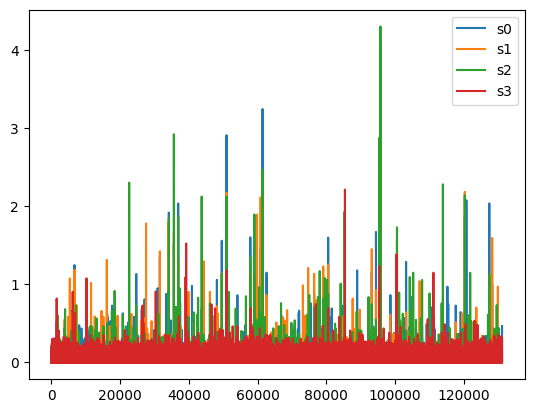

In [6]:
# prompt_features = last_acts[0].pre_acts[-1]
plt.plot(last_acts[0].pre_acts[-1], label="s0")
plt.plot(last_acts[1].pre_acts[-1], label="s1")
plt.plot(last_acts[2].pre_acts[-1], label="s2")
plt.plot(last_acts[3].pre_acts[-1], label="s3")

plt.legend()

Identify features that were most activated by iterating through our text samples and tallying up how many times a feature appeared in the top_k reported by the SAE's encoder half.

In [7]:
acc = torch.zeros(131072)
for x in range(1, len(last_acts)):
    acc[last_acts[x].top_indices[-1]] += 1

common_acts = torch.topk(acc, k=64)

In [8]:
ctx = {}
print(common_acts)
ctx["index"] = common_acts.indices[0]
ctx["value"] = 10.0
ctx["steer"] = True

torch.return_types.topk(
values=tensor([5., 5., 5., 5., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]),
indices=tensor([103171,  50990,  95376, 101422, 120238,  57895,  59939,  60888,   6777,
         35674,  80526, 127359, 100531,  94423,  95717,  10281,  54132,  48184,
         14649,  36926,  37128,  35149,  62134,  84576,  11351, 122107,  26819,
         26555,  92365,  15312,  61456, 101155,  24738,  12674,  59371,  59659,
         59295,  59841,  59090,  51700,  56617,  49600,  47133,  41446,  43705,
         41195,  46156,  39916,  39074,  36135,  60164,  46594,  38736,  34215,
         31384,  31608,   4901,   4367,  32664,  30956,  30634,  28209,   3913,
         34087]))


Hooks allow inspection or modification of the inputs/outputs of torch modules without modification to the module.
Since we pass hidden_state to our SAE in the earlier cell, this hooks replaces hidden_state, which is the incoming value to the transformer layer, by passing it through the encoder first.
ctx allows us to tell the hook how to modify SAE features, which we manipulate later to steer the model.

In [9]:
try:
    steering_hook_handle.remove()
except NameError:
    print("No handle set yet. Assuming this is the first run.")

cached_in = None

# Hooks allow inspection or modification of the inputs/outputs of torch modules
# without modification to the module.
# Since we pass hidden_state to our SAE in the earlier cell, this hooks replaces
# hidden_state, which is the incoming value to the transformer layer, by 
# passing it through the encoder first.
# ctx allows us to tell the hook how to modify SAE features, which we manipulate
# later to steer the model.
def steering_hook(mod, ins):
    global cached_in
    global sae
    global ctx

    latent = sae.encode(ins[0].squeeze(0))

    if ctx["steer"]:
        act_index = (latent.top_indices[0, :] == ctx["index"]).nonzero(as_tuple=True)

        # If the target feature is already in the top acts, force it to the desired value.
        if len(torch.tensor([])) != 0:
            latent.top_acts[0, act_index] = ctx["value"]
            out = sae.decode(latent.top_acts, latent.top_indices)
            cached_in = out
            out = (out.unsqueeze(0),)
            ins[0][...] = out[0][...]
            return None
        # If not, then extend the top acts arrays to add it.
        else:
            ps, fv = latent.top_indices.shape
            new_top_acts = torch.zeros(ps, fv + 1, dtype=latent.top_acts.dtype)
            new_top_indices = torch.zeros(ps, fv + 1, dtype=latent.top_indices.dtype)

            new_top_acts[:, 1:] = latent.top_acts
            new_top_indices[:, 1:] = latent.top_indices

            new_top_acts[:, 0] = ctx["value"]
            new_top_indices[:, 0] = ctx["index"]

            out = sae.decode(new_top_acts, new_top_indices)
            cached_in = out
            out = (out.unsqueeze(0),)

            # Confusingly it seems we need to mutate the input. Idk what the return value is for.
            ins[0][...] = out[0][...]
            return None
    
    # Fallback, pass through the input.
    return ins

steering_hook_handle = model.model.layers[24].register_forward_pre_hook(steering_hook)

No handle set yet. Assuming this is the first run.


# First get the unmodified input from the model.

In [10]:
ctx["steer"] = False

print(ctx)

transformers.set_seed(17)
with torch.inference_mode():
    inputs = tokenizer("I", return_tensors="pt")
    # outputs = model(**inputs, output_hidden_states=True)
    gen = model.generate(**inputs, do_sample=True, max_length=32, temperature=1.0)

    print(tokenizer.batch_decode(gen, skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


{'index': tensor(103171), 'value': 10.0, 'steer': False}
['I’m pretty sure that the answer to every question is “yes”. That said, we do have a list of frequently asked questions (and the answers)']


# Try forcing different common features high

In [11]:
for x in range(0, 10):
    ctx["index"] = common_acts.indices[x]
    ctx["steer"] = True
    ctx["value"] = 5.0
    
    print(ctx)
    
    transformers.set_seed(17)
    with torch.inference_mode():
        inputs = tokenizer("I", return_tensors="pt")
        # outputs = model(**inputs, output_hidden_states=True)
        gen = model.generate(**inputs, do_sample=True, max_length=32, temperature=1.0)
    
        print(f"Feature {x}", tokenizer.batch_decode(gen, skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


{'index': tensor(103171), 'value': 5.0, 'steer': True}


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Feature 0 ['I love to travel, and I love to experience the world from the perspective of the people I’m with. In my life I have been fortunate to have']
{'index': tensor(50990), 'value': 5.0, 'steer': True}


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Feature 1 ['I love to travel, and I am also a vegetarian and a food lover. I love to discover the world through its food and to share the best of']
{'index': tensor(95376), 'value': 5.0, 'steer': True}


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Feature 2 ['I n s c. t h. t s. c. t. t...............']
{'index': tensor(101422), 'value': 5.0, 'steer': True}


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Feature 3 ['I love the “p” in “s” sound that many Americans use in the word “s” in the word “s” in the word “']
{'index': tensor(120238), 'value': 5.0, 'steer': True}


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Feature 4 ['I n s p i n c h i n s c h i n t h e r e p s c h i n n w h o t']
{'index': tensor(57895), 'value': 5.0, 'steer': True}


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Feature 5 ["I’m Not Good Enough To Be A\nIt's a phrase that you've heard Before you and I we’re born there was a means of it’s"]
{'index': tensor(59939), 'value': 5.0, 'steer': True}


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Feature 6 ['I']
{'index': tensor(60888), 'value': 5.0, 'steer': True}


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Feature 7 ['I’m not a big football fan. I was never a football player. In fact, I never did the sport at all growing up, so I’m']
{'index': tensor(6777), 'value': 5.0, 'steer': True}


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Feature 8 ['I love the “Do” part of “do” \u200b \u200b \u200b \u200b \u200b \u200b \u200b \u200b \u200b \u200b \u200b \u200b \u200b\u200b\u200b \u200b \u200b \u200b \u200b\u200b']
{'index': tensor(35674), 'value': 5.0, 'steer': True}
Feature 9 ['I love to travel, and I can’t think of a better way to experience a new city than to learn about it’s food and culture. If you']


Ok, feature 7 says something about football which is promising. Although my samples were all about baseball, anything sports related is a good hit. Let's make some generations from open-ended prompts to see if they start talking about sports. Remember that this is not an instruct model, so the samples should not take the form of questions/requests/chats.

In [12]:
prompts = [
    "There are plenty of things to do when visiting a new city, such as",
    "Staying active is an important part of a healthly lifestyle.",
    "My favorite thing to do with friends on the weekend is",
    "The"
]

for p in prompts:
    ctx["index"] = common_acts.indices[7]
    ctx["steer"] = True
    ctx["value"] = 6.0  # 4 not enough, 10 too much.

    transformers.set_seed(17)
    with torch.inference_mode():
        inputs = tokenizer(p, return_tensors="pt")
        # outputs = model(**inputs, output_hidden_states=True)
        gen = model.generate(**inputs, do_sample=True, max_length=32, temperature=0.5, top_p=0.95)
    
        print(tokenizer.batch_decode(gen, skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


['There are plenty of things to do when visiting a new city, such as visiting the football or soccer games, but there is also a lot of fun to']


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


["Staying active is an important part of a healthly lifestyle. But when you're in sports or are an athlete, it's important to be sure you"]


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


['My favorite thing to do with friends on the weekend is to get together for a football or soccer game. It’s a great time to play some football or']
['The goal of this project is to develop and test a new, football style, soccer goal. This goal will be made of a basketball goal and will be']
